<a href="https://colab.research.google.com/github/cianyu12/Credit-risk-study/blob/main/Credit_Risk_Approval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Credit Risk Model for improving approval process.

Data was collected by https://www.kaggle.com/datasets/laotse/credit-risk-dataset

# Credit Risk Approval

## Library in used

In [1]:
!pip install feature_engine
!pip install catboost
#basic
import numpy as np
import pandas as pd
#plot
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn and model
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError

import warnings, gc
warnings.filterwarnings("ignore")

## Read data

In [2]:
path = '/content/sample_data/credit_risk_dataset.csv'
df = pd.read_csv(path)
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Drop the duplicate rows

In [3]:
df = df.drop_duplicates()

Check null values

In [4]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [5]:
df = df.dropna()
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [6]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

### Data Description

In [7]:
#Categorical variable

cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

#Continuous variable

con_cols = [col for col in df.columns if df[col].dtypes != 'O']

cat_but_con = [col for col in df.columns if df[col].dtypes == 'O' and df[col].nunique() > 20]

con_but_cat = [col for col in df.columns if df[col].dtypes != 'O' and df[col].nunique() < 10]

print(f"Observation: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Categorical variable: {len(cat_cols)}")
print(f"Continuous variable: {len(con_cols)}")
print(f"Continuous variable but in string: {len(con_but_cat)}")
print(f"Categorical variable but in number: {len(cat_but_con)}")


Observation: 28501
Variables: 12
Categorical variable: 4
Continuous variable: 8
Continuous variable but in string: 1
Categorical variable but in number: 0


### Find Correlation for each variable

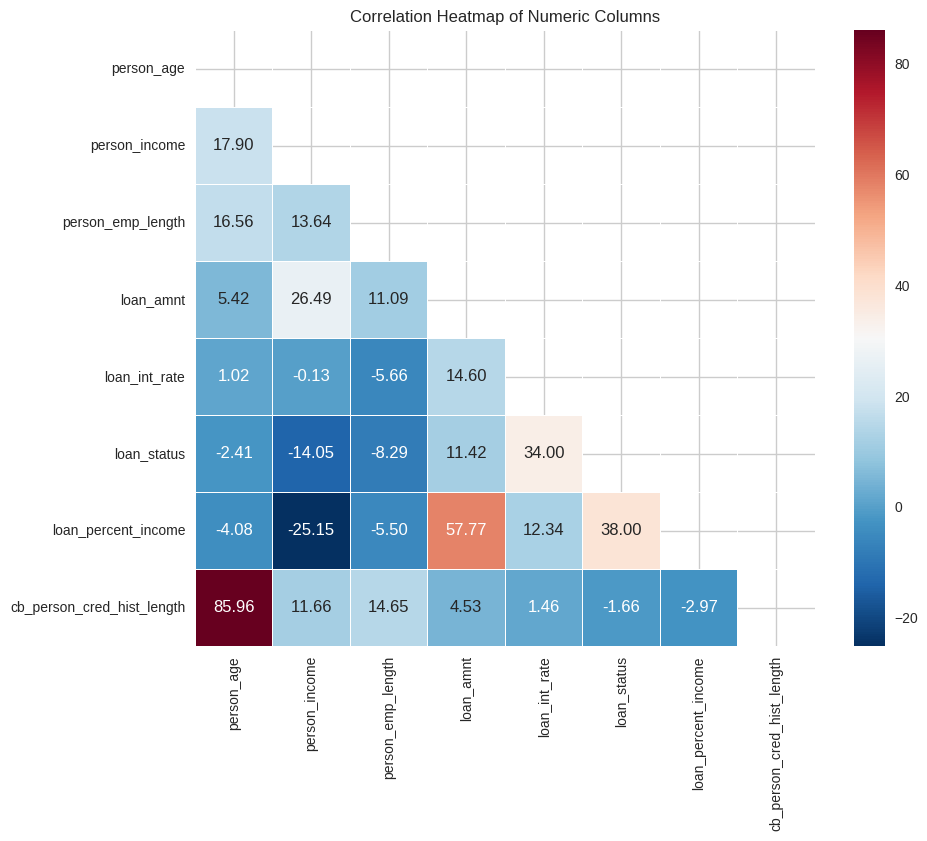

In [8]:
# Assuming your DataFrame is named 'df' and contains the specified columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_data = df[numeric_cols]

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a custom colormap for red-black tones
cmap = sns.color_palette("RdBu_r", as_cmap=True)

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix * 100, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()



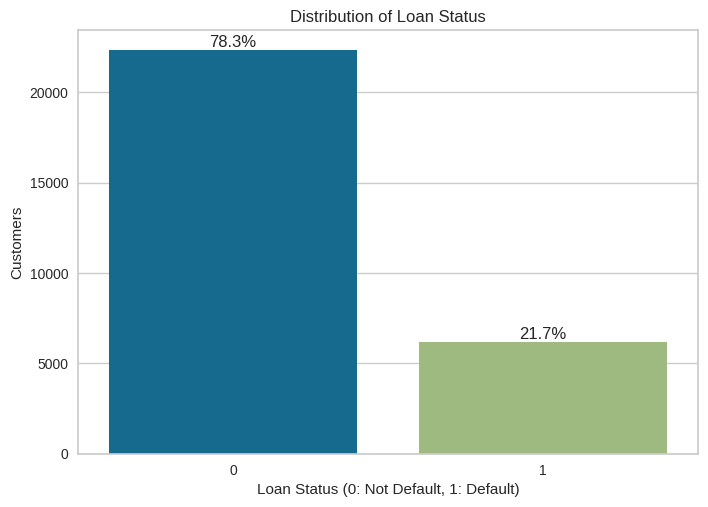

In [9]:
total_records = len(df)
ax = sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (0: Not Default, 1: Default)')
plt.ylabel('Customers')

# Annotate with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_records)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()


## Data Cleaning

### Outlier

In [10]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in con_cols:
    if col != "loan_status":
      print(col, check_outlier(df, col))

person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length True


Then We will fix the loan_amnt and loan_int_rate with low and up limit to delete outlier.

In [11]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in con_cols:
    if col != "loan_status":
        replace_with_thresholds(df,col)

## Feature Engineering

### Age

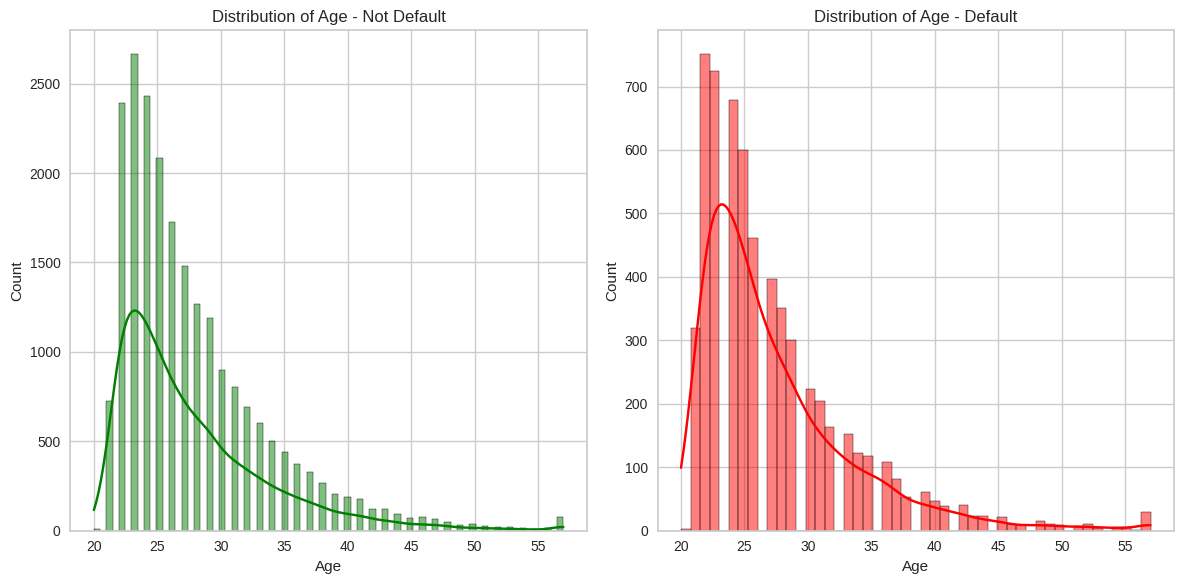

In [12]:
plt.figure(figsize=(12, 6))

# Plot for loan_status 0 (Not Default)
plt.subplot(1, 2, 1)
sns.histplot(df[df['loan_status'] == 0]['person_age'], kde=True, color='green')
plt.title('Distribution of Age - Not Default')
plt.xlabel('Age')
plt.ylabel('Count')

# Plot for loan_status 1 (Default)
plt.subplot(1, 2, 2)
sns.histplot(df[df['loan_status'] == 1]['person_age'], kde=True, color='red')
plt.title('Distribution of Age - Default')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


The distribution of Age for each loan status are the same.

### House Ownership

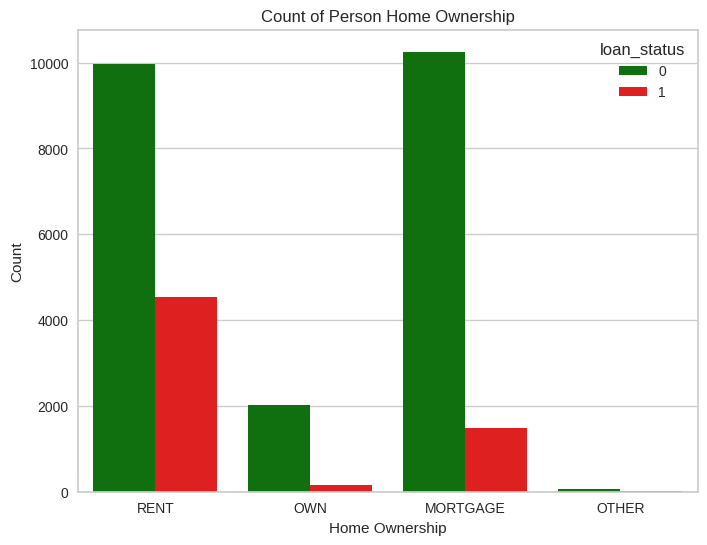

In [13]:
# Assuming your DataFrame is named 'df'
plt.figure(figsize=(8, 6))

custom_palette = {0: 'green', 1: 'red'}

# Count plot for person_home_ownership
sns.countplot(x='person_home_ownership',hue = 'loan_status',data=df,palette = custom_palette)

plt.title('Count of Person Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()


The high percentage of default came from rent and mortage type.

### Loan Grade

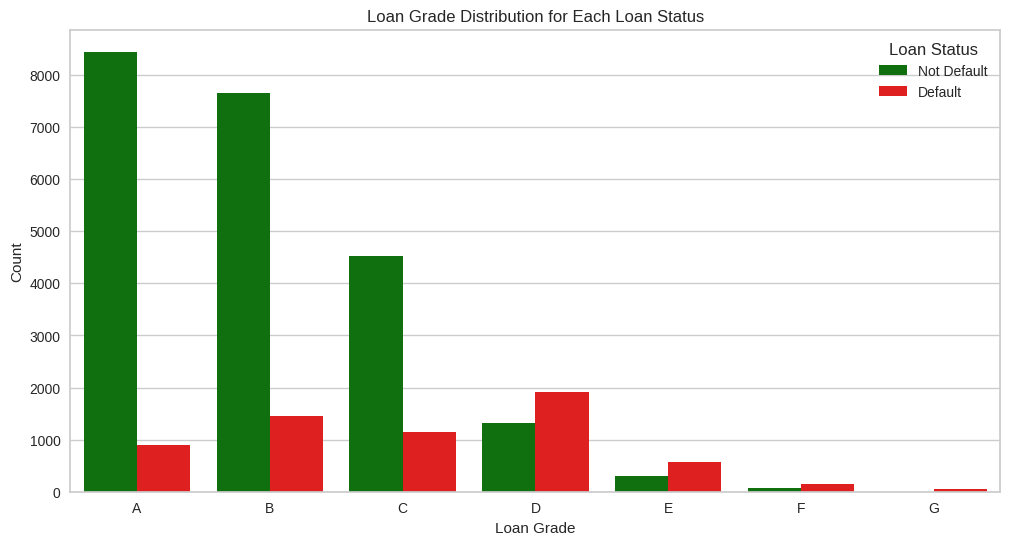

In [14]:
plt.figure(figsize=(12, 6))

# Custom colors: red for loan_status = 1 (Default), green for loan_status = 0 (Not Default)
custom_palette = {0: 'green', 1: 'red'}

# Order of loan_grade from A to Z
grade_order = sorted(df['loan_grade'].unique())

# Grouped bar chart for loan_grade and loan_status with custom colors and sorted order
sns.countplot(x='loan_grade', hue='loan_status', data=df, palette=custom_palette, order=grade_order)

plt.title('Loan Grade Distribution for Each Loan Status')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Default', 'Default'])
plt.show()

The loan grade from D-G show a high default.

### Loan intent

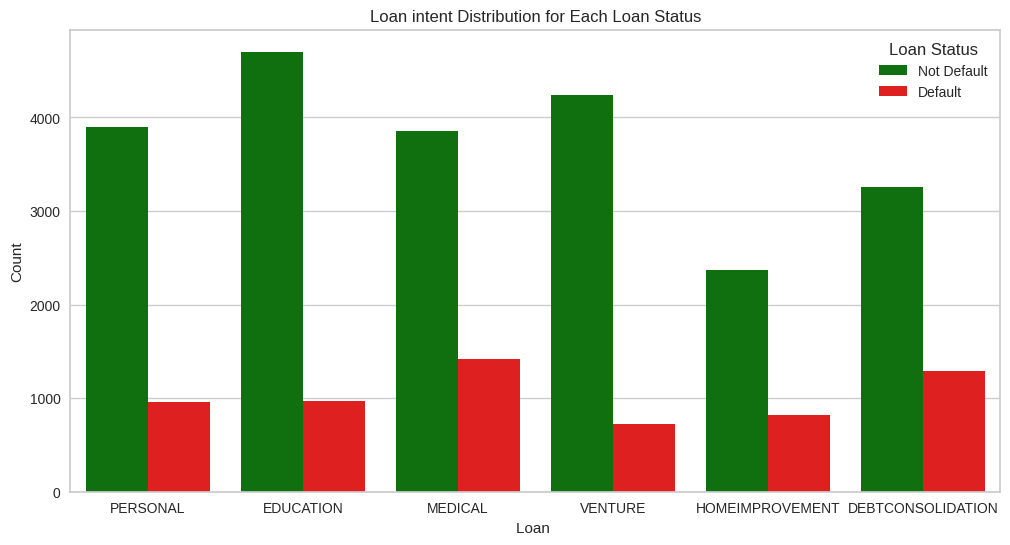

In [15]:
plt.figure(figsize=(12, 6))

# Custom colors: red for loan_status = 1 (Default), green for loan_status = 0 (Not Default)
custom_palette = {0: 'green', 1: 'red'}

# Order of loan_grade from A to Z

# Grouped bar chart for loan_grade and loan_status with custom colors and sorted order
sns.countplot(x='loan_intent', hue='loan_status', data=df, palette=custom_palette)

plt.title('Loan intent Distribution for Each Loan Status')
plt.xlabel('Loan ')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Default', 'Default'])
plt.show()

In [16]:
def plot_distribution(df, column):
    plt.figure(figsize=(10, 6))

    # Custom colors: red for loan_status = 1 (Default), green for loan_status = 0 (Not Default)
    custom_palette = {0: 'green', 1: 'red'}

    # Plot KDE for each loan status
    for status in [0, 1]:
        subset = df[df['loan_status'] == status]
        sns.kdeplot(subset[column], label=f'Loan Status {status}', color=custom_palette[status], fill=True)

    plt.title(f'Kernel Density Estimate of {column} for Each Loan Status')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


### Loan Amount

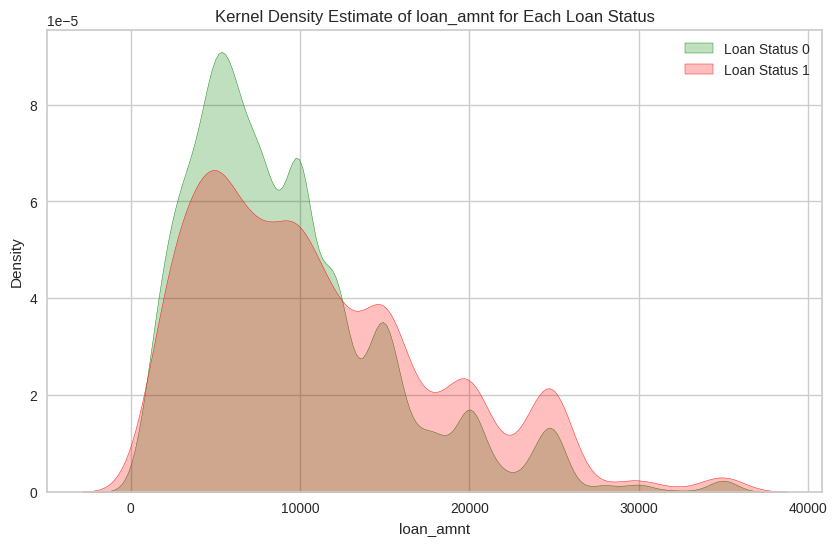

In [17]:
plot_distribution(df,'loan_amnt')

### Person_income

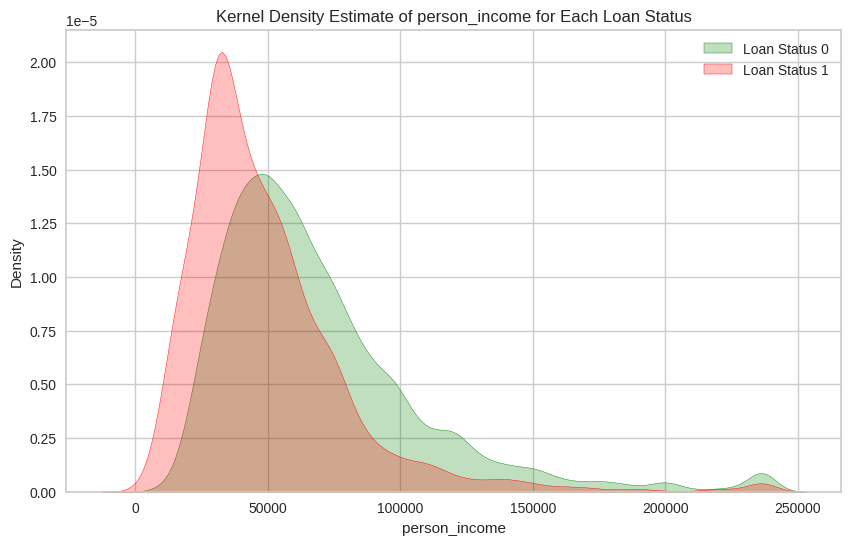

In [18]:
plot_distribution(df,'person_income')

### Loan interest rate

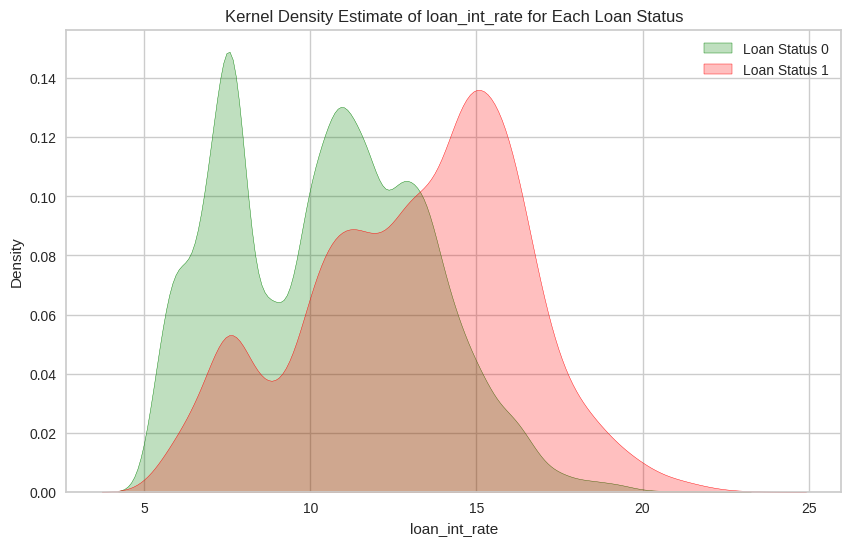

In [19]:
plot_distribution(df,'loan_int_rate')

### Person employee Legnth

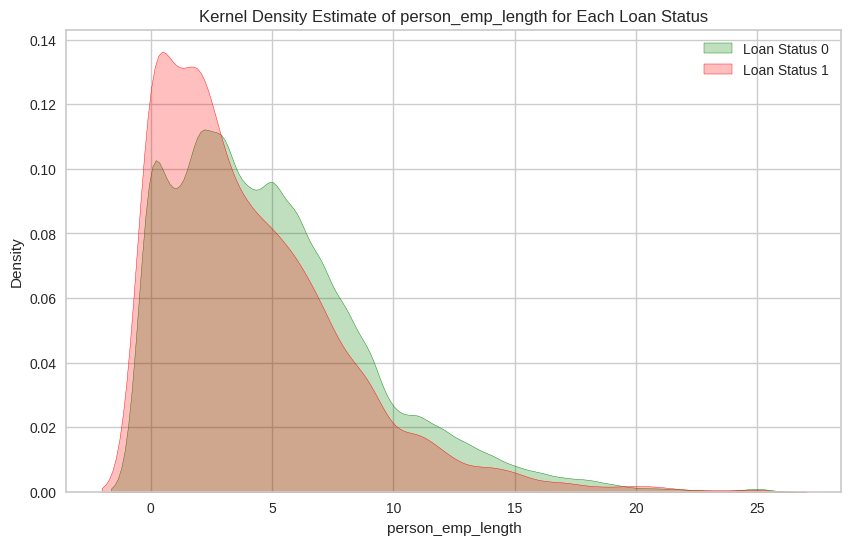

In [20]:
plot_distribution(df,'person_emp_length')

In [21]:
df['income_interval'] = pd.cut(df['person_income'],
                                                        bins=5,
                                                        labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

## CB cb_person_cred_hist_length

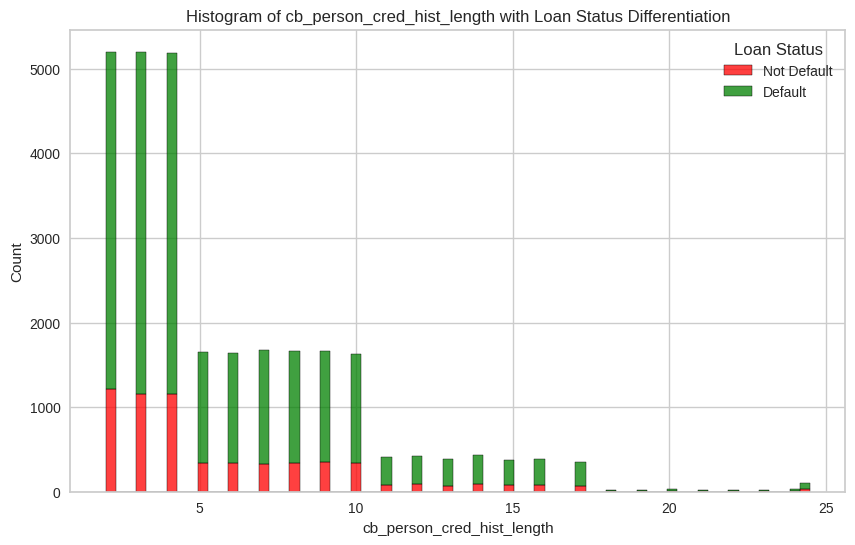

In [22]:
plt.figure(figsize=(10, 6))

# Plot histogram with color differentiation for loan_status
sns.histplot(data=df, x='cb_person_cred_hist_length', hue='loan_status', bins='auto', multiple='stack', palette={0: 'green', 1: 'red'})

plt.title('Histogram of cb_person_cred_hist_length with Loan Status Differentiation')
plt.xlabel('cb_person_cred_hist_length')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Default', 'Default'])
plt.show()


## Feature engineering and pre-processing data

Regarding to the distribution of Age is the same for both loan status so we cut it off.

In [23]:
type(cat_cols)

list

In [24]:
#Feature
df_feature = df.copy()

categorical_cols = cat_cols.append('income_interval')

df_feature = pd.get_dummies(df_feature, columns=categorical_cols, drop_first=True,dtype=int)
# Display the resulting DataFrame
print(df_feature.head())

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000               25.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1                 0.59                         3.0   
1            0                 0.10                         2.0   
2            1                 0.57                         3.0   
3            1                 0.53                         2.0   
4            1                 0.55                         4.0   

   person_home_ownership_OTHER  person_home_ownership_OWN  ...  loan_grade_C  \
0                            0                        

In [25]:
df_feature.shape

(28501, 27)

In [26]:
#Feature
X = df_feature.drop(['loan_status','person_age','person_income'],axis=1)
#Target variable
Y = df_feature['loan_status']

## ML part

In [27]:
#Create Pipeline
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(28501, 24)

In [28]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42,stratify=Y)
#scaling variables
scaler = StandardScaler()
#scaler= RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)
scaled_test_X = scaler.transform(X_test)

In [29]:
#ROC curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_test,y_pred):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [30]:
import re
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

def train_and_evaluate_model(model):
    model.fit(scaled_train_X,y_train)
    y_pred = model.predict(scaled_test_X)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    plot_roc_curve(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')

    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(scaled_test_X,y_test)
        visualizer.show()
        del visualizer

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()

### CatBoost Model

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4463
           1       0.96      0.70      0.81      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.85      0.88      5701
weighted avg       0.93      0.93      0.92      5701

--------------------------------------------------


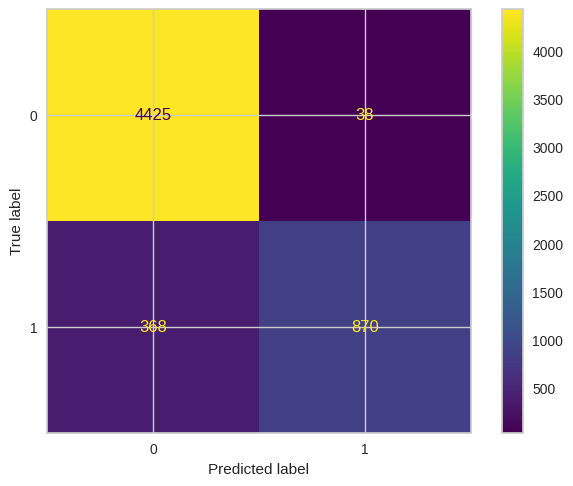

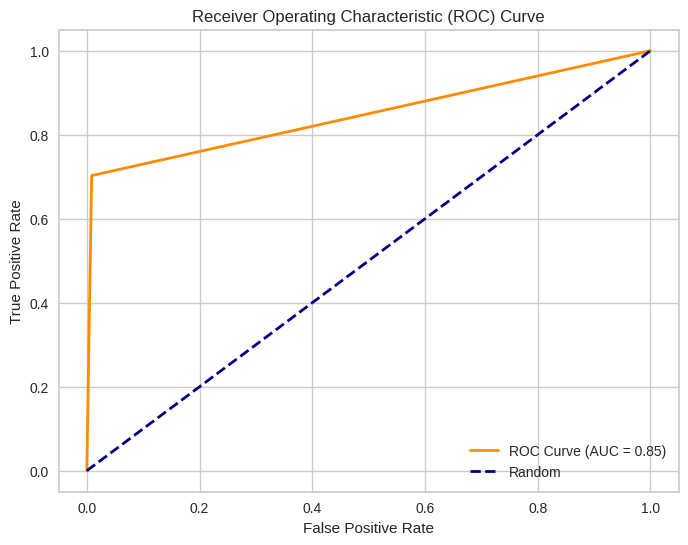

In [31]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

### Light GBM

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4463
           1       0.96      0.70      0.81      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.84      0.88      5701
weighted avg       0.93      0.93      0.92      5701

--------------------------------------------------


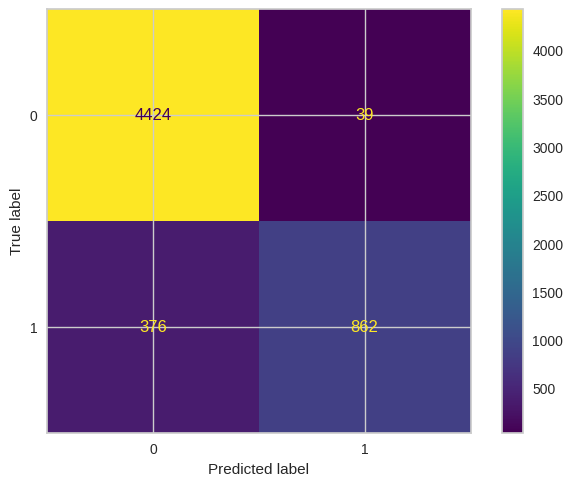

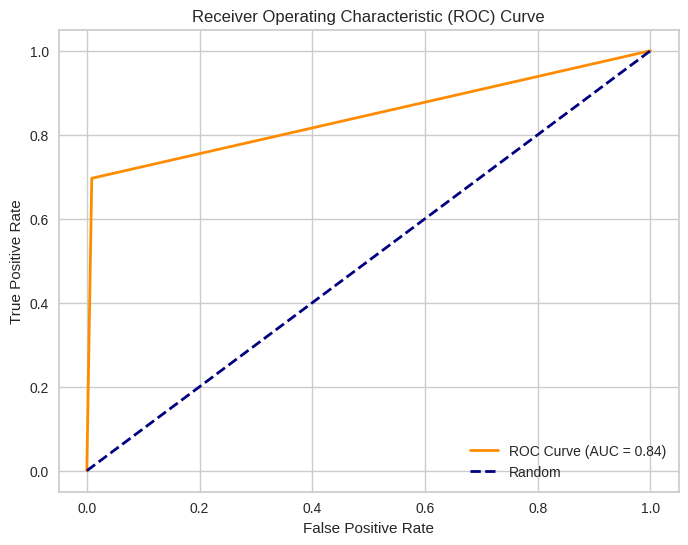

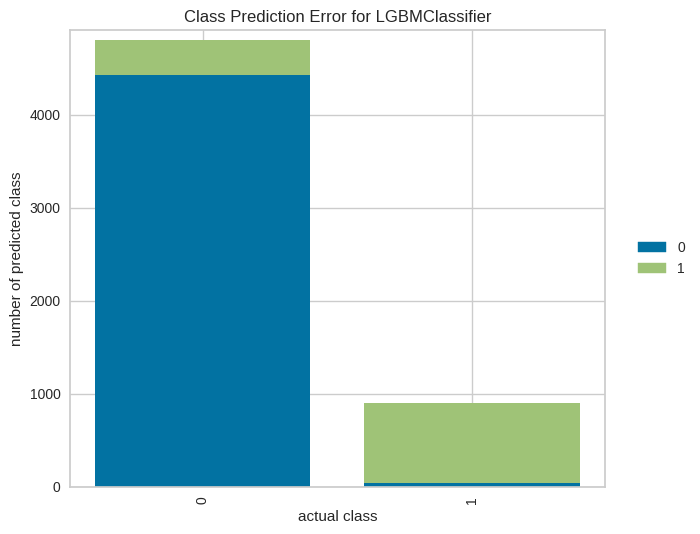

In [32]:
#Setting verbose=-1 means that the algorithm will operate silently without printing any progress or information to the console
train_and_evaluate_model(LGBMClassifier(verbose=-1))

### Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4463
           1       0.93      0.68      0.78      1238

    accuracy                           0.92      5701
   macro avg       0.92      0.83      0.87      5701
weighted avg       0.92      0.92      0.91      5701

--------------------------------------------------


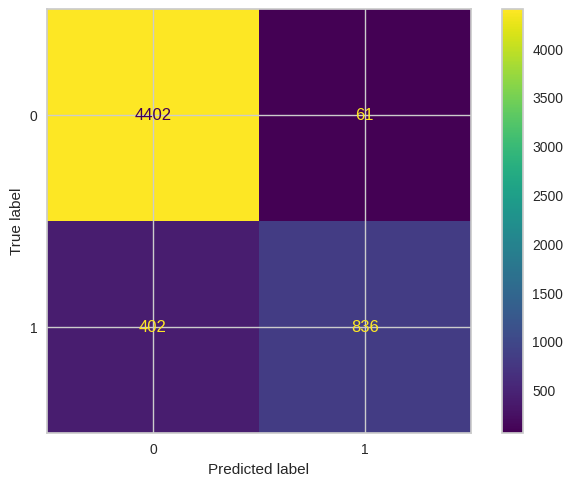

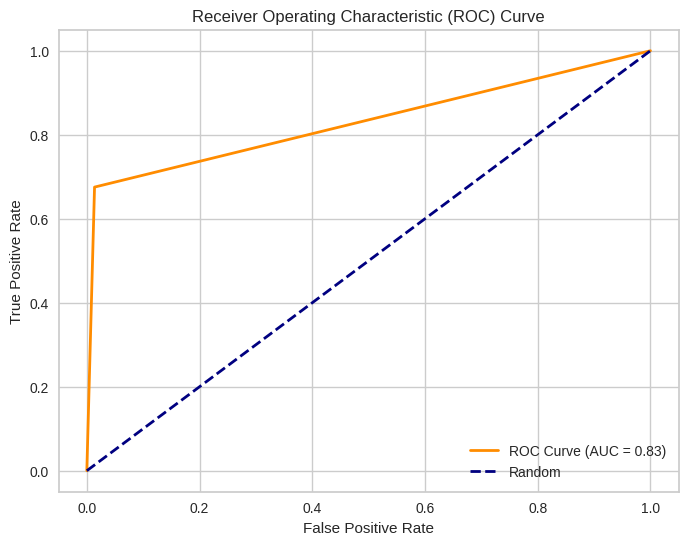

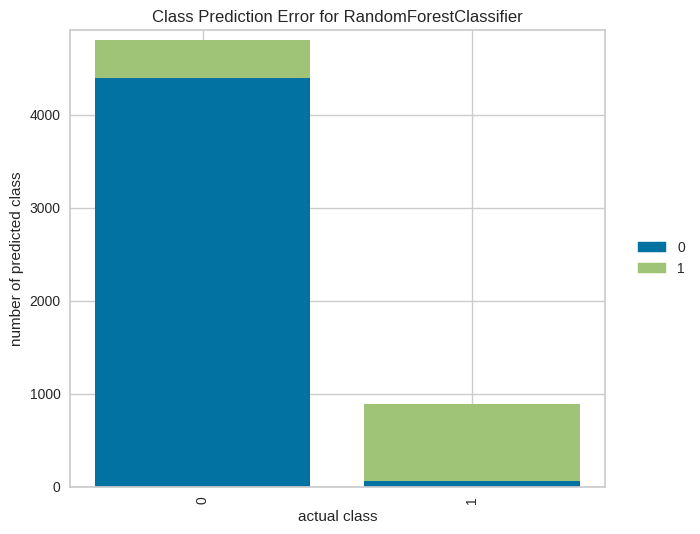

In [33]:
from sklearn.ensemble import RandomForestClassifier
train_and_evaluate_model(RandomForestClassifier())

### XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4463
           1       0.94      0.70      0.80      1238

    accuracy                           0.93      5701
   macro avg       0.93      0.84      0.88      5701
weighted avg       0.93      0.93      0.92      5701

--------------------------------------------------


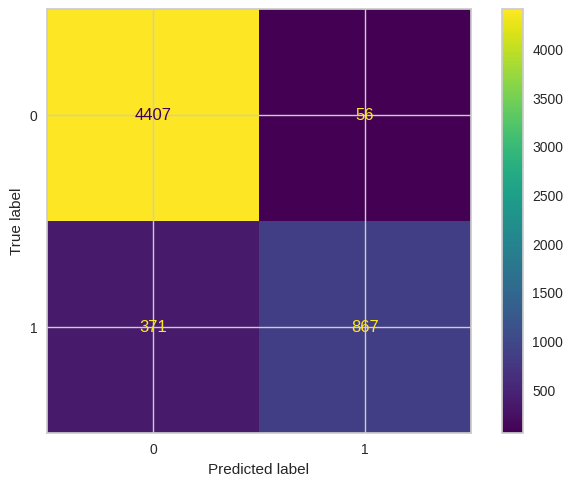

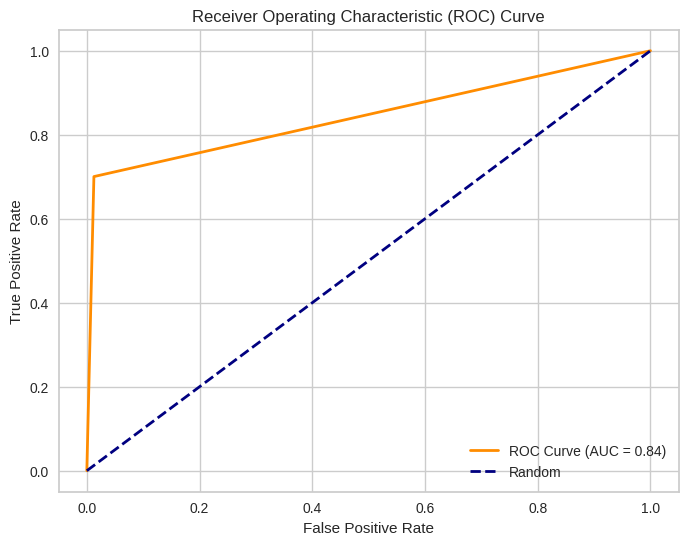

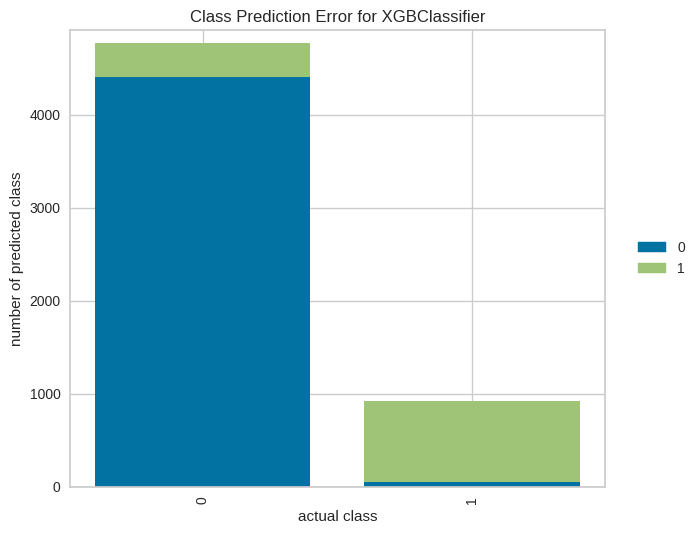

In [34]:
train_and_evaluate_model(XGBClassifier())

## Model Evaluation

In [35]:
model_performance = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_performance['Model'] = ['CatBoost','LGBM','XGboost','Randomforest']

In [36]:
model_performance

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,CatBoost,0.928784,0.940686,0.847116,0.883474,0.847116
1,LGBM,0.927206,0.939191,0.843773,0.880591,0.843773
2,XGboost,0.925101,0.930840,0.843888,0.878100,0.843888
3,Randomforest,0.918786,0.924158,0.830807,0.866588,0.830807


## Feature importance

In [37]:
Catmodel = CatBoostClassifier(silent=True)
Catmodel.fit(X,Y)

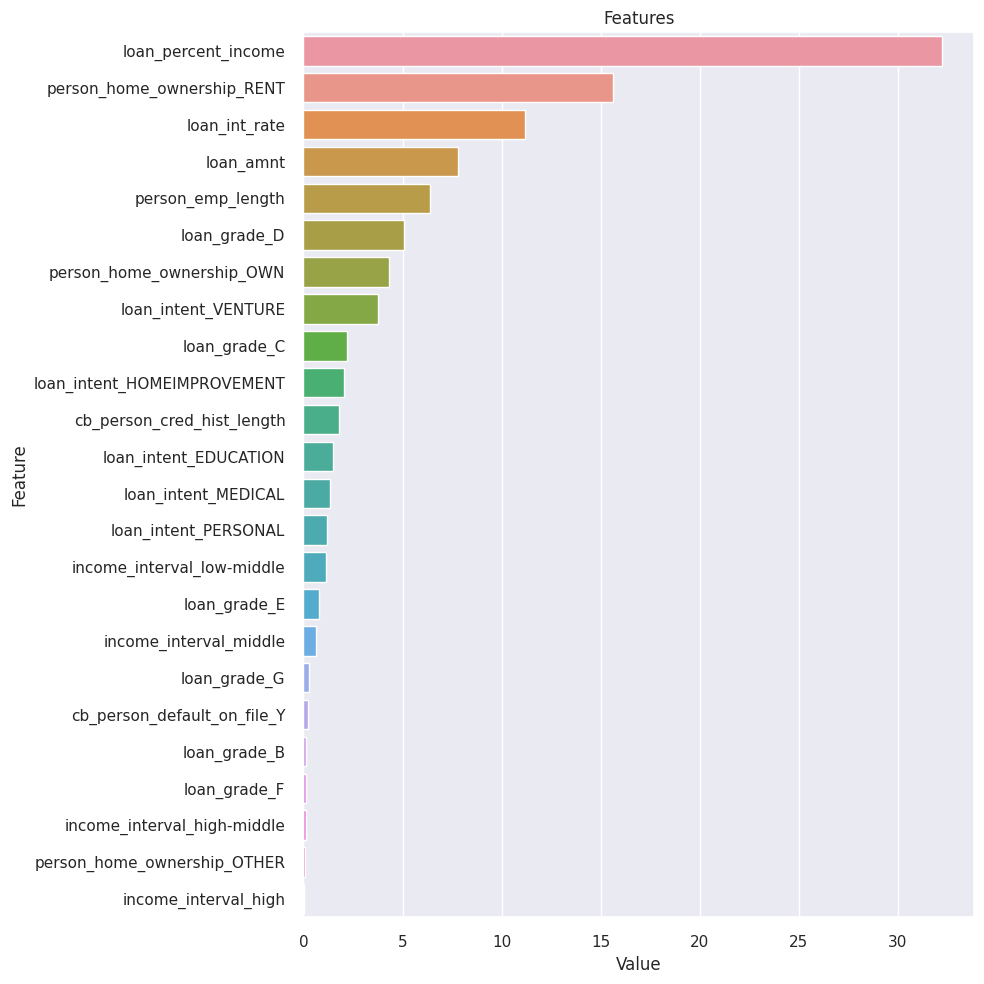

In [38]:
feature_imp = pd.DataFrame({"Value": Catmodel.feature_importances_, "Feature": X.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:len(X)])
plt.title("Features")
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22313
           1       0.99      0.74      0.85      6188

    accuracy                           0.94     28501
   macro avg       0.96      0.87      0.91     28501
weighted avg       0.95      0.94      0.94     28501

--------------------------------------------------


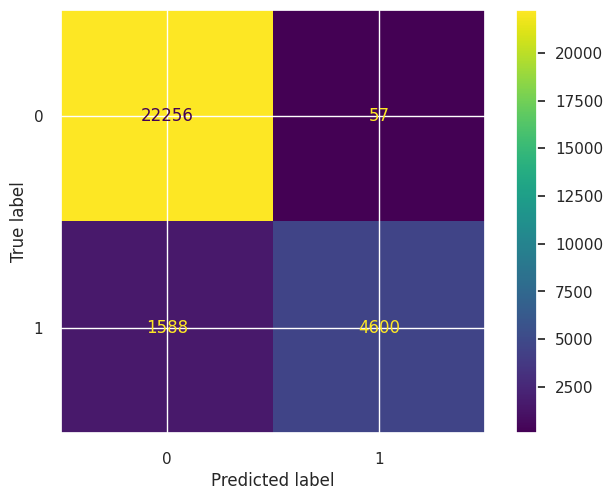

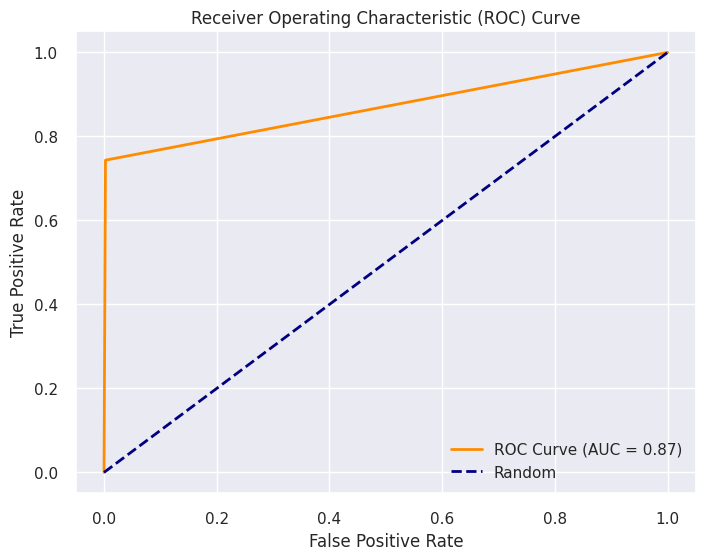

In [39]:
y_pred = Catmodel.predict(X)
print("Classification Report:")
print(classification_report(Y,y_pred))
print('-'*50)
ConfusionMatrixDisplay.from_predictions(Y,y_pred)
plot_roc_curve(Y,y_pred)

# Credit Scoring

## Weight of Evidenct WOE

In [40]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'income_interval'],
      dtype='object')

In [41]:
df['emp_length_interval'] = pd.qcut(df['person_emp_length'],5,duplicates='drop')
df['loan_amount_interval'] = pd.qcut(df['loan_amnt'],5,duplicates = 'drop')
df['loan_int_rate_interval'] = pd.qcut(df['loan_int_rate'],5,duplicates = 'drop')
df['loan_percent_income_interval'] = pd.qcut(df['loan_percent_income'],10,duplicates ='drop')
df['Age_interval'] = pd.qcut(df['person_age'],10,duplicates='drop')

In [42]:
#Select factor
df_score = df.copy()
#Change non-default -> 1 -> survive
df_score['loan_status'] = np.where(df_score['loan_status'] == 1,0,1)


factor = ['Age_interval','income_interval','person_home_ownership','loan_intent','loan_grade','loan_amount_interval','emp_length_interval','loan_int_rate_interval','loan_percent_income_interval','cb_person_default_on_file']
factor_sum =[]

for fac in factor:
    df_fac = pd.concat([df_score.groupby([fac])['loan_status'].count(),df_score.groupby([fac])['loan_status'].sum()]
                       ,axis=1,keys=['Number','default']).rename_axis('Interval').reset_index()
    df_fac['Factor'] = fac
    df_fac['default_rate'] = df_fac['default'] / df_fac['Number']
    df_fac['default_percent'] = df_fac['default'] / df_fac['default'].sum()
    df_fac['Non_default'] = df_fac['Number'] - df_fac['default']
    df_fac['Non_default_rate'] = 1-df_fac['default_rate']
    df_fac['Non_default_percent'] = df_fac['Non_default'] / df_fac['Non_default'].sum()
    ## Good / Bad Non default -> survive
    df_fac['WOE'] = np.log(df_fac['Non_default_percent'] / df_fac['default_percent'])
    df_fac['IV'] = (df_fac['Non_default_percent'] - df_fac['default_percent']) * df_fac['WOE']
    factor_sum.append(df_fac)

factor_sum = pd.concat(factor_sum,ignore_index=True)

In [43]:
#IV
iv = factor_sum.groupby(['Factor'])['IV'].sum().sort_values()
iv

Factor
Age_interval                    0.009944
emp_length_interval             0.054444
loan_amount_interval            0.082703
loan_intent                     0.098088
cb_person_default_on_file       0.170484
income_interval                 0.283836
person_home_ownership           0.376693
loan_int_rate_interval          0.715667
loan_percent_income_interval    0.881664
loan_grade                      0.922052
Name: IV, dtype: float64

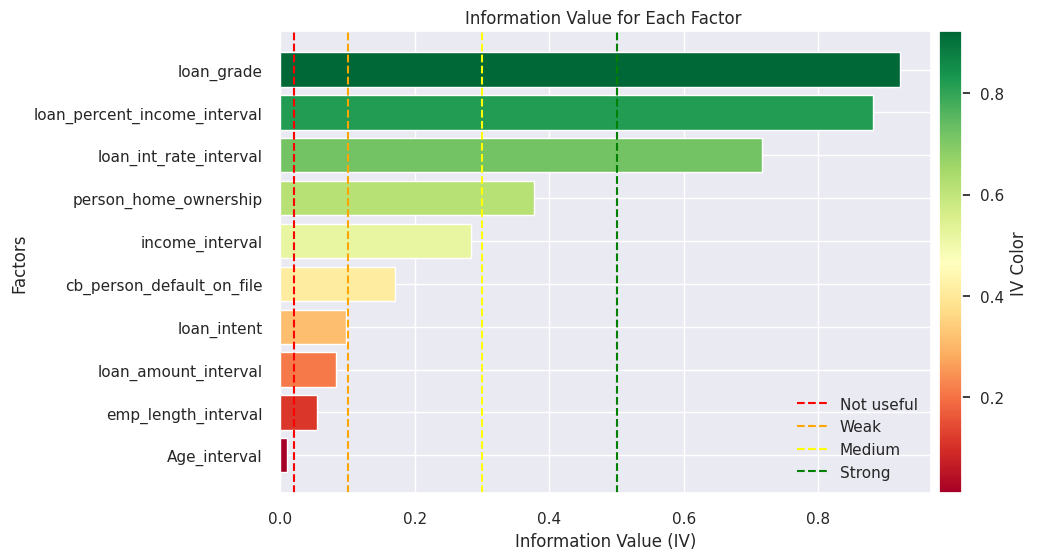

In [44]:
transposed_df = factor_sum.pivot_table(index='Factor', values='IV', aggfunc='sum').T

# Set up colors for the horizontal bar graph with red to green divergence
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(transposed_df.columns)))

# Sort the factors based on their values
sorted_factors = transposed_df.columns[np.argsort(transposed_df.values[0])]

# Plot the horizontal bar graph
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_factors, transposed_df[sorted_factors].values[0], color=colors)

# Add reference lines and labels
plt.axvline(x=0.02, color='red', linestyle='--', label='Not useful')
plt.axvline(x=0.1, color='orange', linestyle='--', label='Weak')
plt.axvline(x=0.3, color='yellow', linestyle='--', label='Medium')
plt.axvline(x=0.5, color='green', linestyle='--', label='Strong')

# Add labels and title
plt.xlabel('Information Value (IV)')
plt.ylabel('Factors')
plt.title('Information Value for Each Factor ')

# Add color bar legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=transposed_df.min().min(), vmax=transposed_df.max().max()))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', pad=0.01)
cbar.set_label('IV Color')

# Add legend
plt.legend()

# Show the plot
plt.show()


### Result from IV

- Loan Grade : This variable has a high IV of 0.922052, indicating that loan grade is a very strong predictor of credit risk. It's a crucial factor in distinguishing between default and non-default customers.

- Loan Percent Income Interval : This variable has a very high IV of 0.881664, indicating that the ratio of loan amount to income, when categorized in intervals, is a powerful predictor of credit risk.

- Loan Interest Rate Interval (loan_int_rate_interval): This variable has a high IV of 0.715667, suggesting that the interest rate, when categorized in intervals, is a strong predictor of credit risk.

- Person Home Ownership (person_home_ownership): With an IV of 0.376693, this variable, which likely indicates whether the person owns a home, provides a substantial amount of information in predicting credit risk.

- Income Interval : This variable has a relatively high IV of 0.283836, suggesting that income, as categorized in intervals, provides substantial information in differentiating between default and non-default customers.

- Default on File with an IV of 0.170484, this variable, which likely indicates whether the person has a default on file, seems to have a moderate level of information value in predicting credit risk.

- Loan Intent (loan_intent): With an IV of 0.098088, loan intent provides a moderate amount of information in predicting credit risk.

- Loan Amount Interval : With an IV of 0.082703, loan amount, when categorized in intervals, contributes a moderate amount of information to the credit risk model.

- Employment Length Interval : This variable has an IV of 0.054444, indicating a modest level of information in predicting credit risk based on employment length.

- Age Interval has a relatively low Information Value (IV) of 0.009944. It suggests that age, as categorized in intervals, doesn't provide a strong differentiation between default and non-default customers.





## Applied Logistic regression to calculate credit score

In [45]:
#Create WOE table
df_logic = df.copy()

cols = list(set(factor_sum['Factor']))

for c in cols:
    factor = factor_sum.loc[factor_sum['Factor'] == c]
    df_logic = pd.merge(df_logic, factor[['Interval','WOE']], how = 'left', left_on = c, right_on = 'Interval')
    df_logic = df_logic.drop(['Interval'], axis = 1)
    df_logic.rename(columns = {'WOE':'WOE_' + c}, inplace = True)

In [46]:
##Change non-default -> 1 -> survive
df_logic['loan_status'] = np.where(df_logic['loan_status'] == 1,0,1)

In [47]:
#WOE column
x_col_name = df_logic.filter(regex='^WOE')
#remove column
x_col_name = x_col_name.drop('WOE_Age_interval',axis=1)
x_factor = x_col_name.columns

In [48]:
x_factor

Index(['WOE_income_interval', 'WOE_loan_percent_income_interval',
       'WOE_person_home_ownership', 'WOE_loan_intent', 'WOE_loan_grade',
       'WOE_loan_int_rate_interval', 'WOE_loan_amount_interval',
       'WOE_cb_person_default_on_file', 'WOE_emp_length_interval'],
      dtype='object')

In [49]:
correlation_matrix = numeric_data.corr()
correlation_matrix

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.178987,0.165624,0.054246,0.010170,-0.024091,-0.040782,0.859621
person_income,0.178987,1.000000,0.136427,0.264942,-0.001346,-0.140456,-0.251487,0.116622
person_emp_length,0.165624,0.136427,1.000000,0.110934,-0.056607,-0.082852,-0.055033,0.146486
loan_amnt,0.054246,0.264942,0.110934,1.000000,0.146026,0.114153,0.577708,0.045334
loan_int_rate,0.010170,-0.001346,-0.056607,0.146026,1.000000,0.339995,0.123441,0.014562
loan_status,-0.024091,-0.140456,-0.082852,0.114153,0.339995,1.000000,0.380000,-0.016559
loan_percent_income,-0.040782,-0.251487,-0.055033,0.577708,0.123441,0.380000,1.000000,-0.029690
cb_person_cred_hist_length,0.859621,0.116622,0.146486,0.045334,0.014562,-0.016559,-0.029690,1.000000


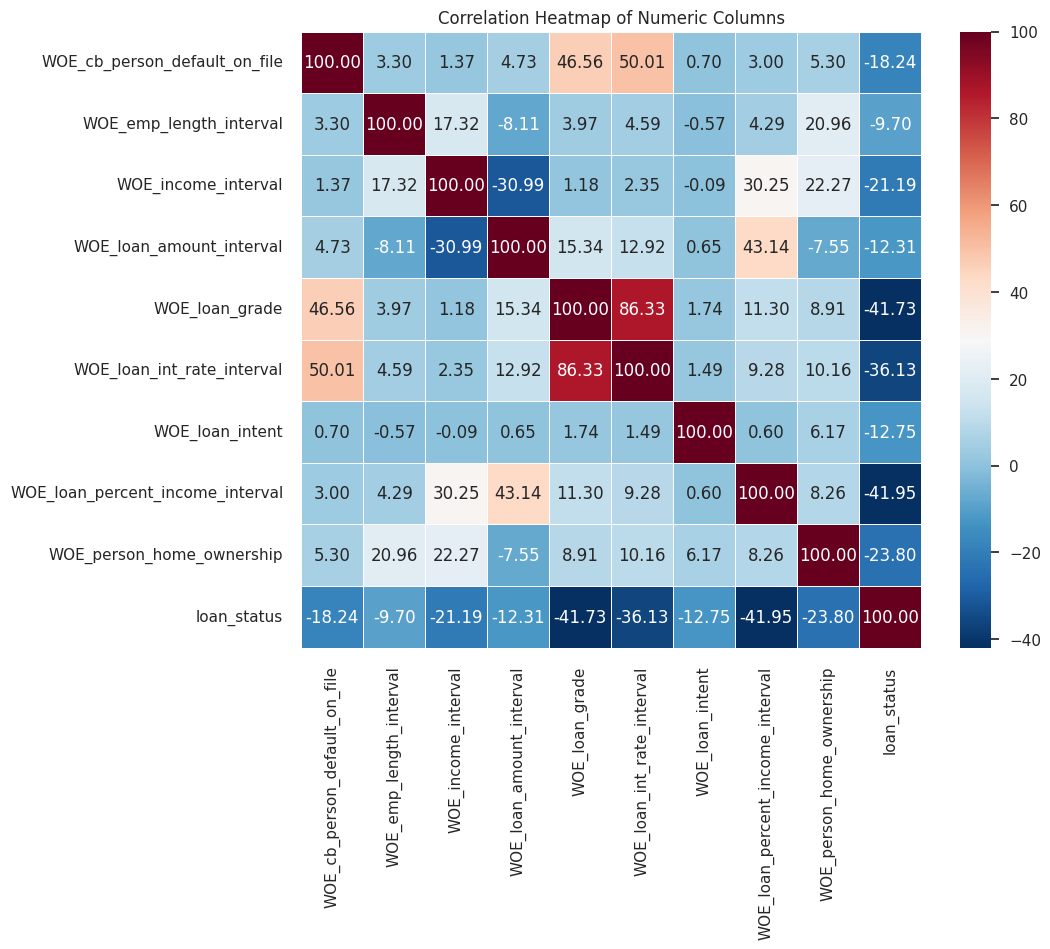

In [50]:
### Heatmap
WOE_cols = x_factor
col_use = pd.Index(['loan_status']).union(WOE_cols)
numeric_data = df_logic[col_use].sort_index(axis=1)


# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()
correlation_matrix_sorted = correlation_matrix.reindex(sorted(correlation_matrix.columns), axis=1)

# Create a custom colormap for red-black tones
cmap = sns.color_palette("RdBu_r", as_cmap=True)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_sorted * 100, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

## Logistic Regression

### Training

In [51]:
import statsmodels.api as sm

train_logic, test_logic = train_test_split(df_logic, test_size=0.3, random_state=50)

# Print or use the selected columns

# Create a logistic regression model using scikit-learn
X_train = train_logic[x_factor]
y_train = train_logic['loan_status']
X_test = test_logic[x_factor]
y_test = test_logic['loan_status']

model = sm.Logit(y_train,sm.add_constant(X_train))
model_result = model.fit()
print(model_result.summary())

Optimization terminated successfully.
         Current function value: 0.330056
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                19950
Model:                          Logit   Df Residuals:                    19940
Method:                           MLE   Df Model:                            9
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                  0.3702
Time:                        10:07:03   Log-Likelihood:                -6584.6
converged:                       True   LL-Null:                       -10456.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.3562      0.023     57.97

According to the result, we saw 'WOE_cb_person_default_on_file' and 'WOE_loan_int_rate_interval' that their P-value > 0.05, so we cut it off. Moreover, the coef value of 'WOE_loan_amount_interval' show a conflict as well.

In [52]:
## Run model ronud 2
x_col_name2 = x_col_name.drop(['WOE_cb_person_default_on_file','WOE_loan_int_rate_interval','WOE_loan_amount_interval'],axis=1)
x_factor2 = x_col_name2.columns

X_train2 = train_logic[x_factor2]
X_test2 = test_logic[x_factor2]

model2 = sm.Logit(y_train,sm.add_constant(X_train2))
model_result2 = model2.fit()
print(model_result2.summary())

Optimization terminated successfully.
         Current function value: 0.330874
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                19950
Model:                          Logit   Df Residuals:                    19943
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                  0.3687
Time:                        10:07:03   Log-Likelihood:                -6600.9
converged:                       True   LL-Null:                       -10456.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.3552      0.023     57.98

Then, we obtain the model that is ready to evaluate next.

### Model Evalatuion

In [53]:
y_pred2 = model_result2.predict()

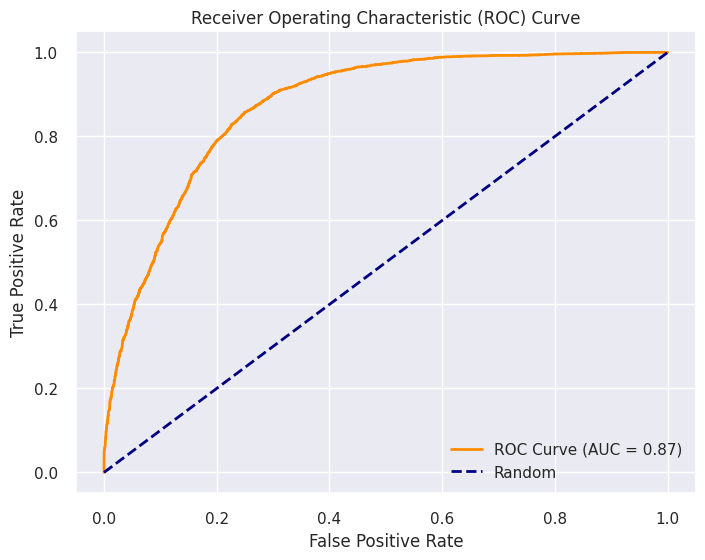

In [54]:
plot_roc_curve(y_train,y_pred2)

In [55]:
from sklearn.metrics import roc_auc_score, mean_squared_error
from scipy import stats

y_train = train_logic['loan_status']
y_pred2 = model_result2.predict()

auc_score = roc_auc_score(y_train, y_pred2)
print("AUC:", auc_score)

# Calculate GINI
gini_score = 2 * auc_score - 1
print("GINI:", gini_score)

# Calculate KS
y_train_ks = pd.DataFrame(train_logic['loan_status'])
y_train_ks['y_pred'] = y_pred2
ks_statistic = stats.ks_2samp(y_train_ks[y_train_ks['loan_status'] == 0]['y_pred'], y_train_ks[y_train_ks['loan_status'] == 1]['y_pred']).statistic
print("KS:", ks_statistic)

# Calculate MSE
mse_score = mean_squared_error(y_train, y_pred2)
print("MSE:", mse_score)

AUC: 0.8740252840091012
GINI: 0.7480505680182024
KS: 0.6074488532894027
MSE: 0.09805745673246526


According to the result that AUC, GINI and KS quite high that indicate the better discrimination.  MSE is quite reasonably small that can indicate that is the good model.

### Testing

In [56]:
model_test = sm.Logit(y_test,sm.add_constant(X_test2))
model_test = model_test.fit()
print(model_test.summary())

Optimization terminated successfully.
         Current function value: 0.338245
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                 8551
Model:                          Logit   Df Residuals:                     8544
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                  0.3510
Time:                        10:07:04   Log-Likelihood:                -2892.3
converged:                       True   LL-Null:                       -4456.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.3595      0.035     38.70

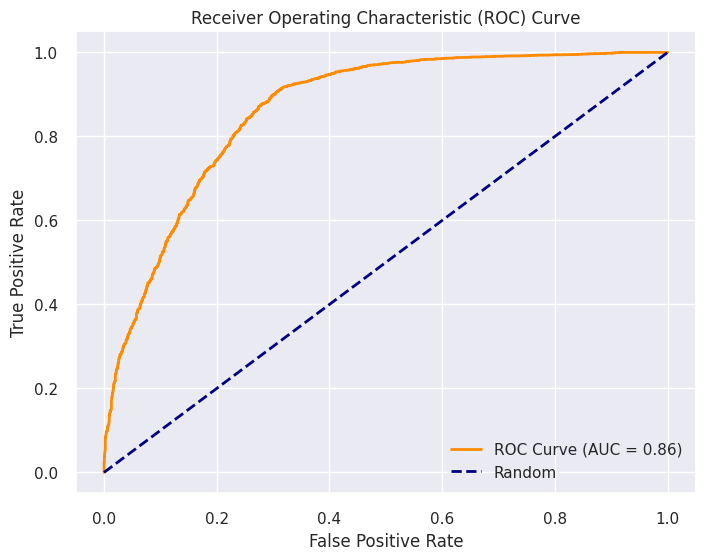

In [57]:
y_pred_test = model_test.predict()
plot_roc_curve(y_test,y_pred_test)

In [58]:
y_test = test_logic['loan_status']

auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC:", auc_score)

# Calculate GINI
gini_score = 2 * auc_score - 1
print("GINI:", gini_score)

# Calculate KS
y_test_ks = pd.DataFrame(test_logic['loan_status'])
y_test_ks['y_pred_test'] = y_pred_test
ks_statistic = stats.ks_2samp(y_test_ks[y_test_ks['loan_status'] == 0]['y_pred_test'], y_test_ks[y_test_ks['loan_status'] == 1]['y_pred_test']).statistic
print("KS:", ks_statistic)

# Calculate MSE
mse_score = mean_squared_error(y_test, y_pred_test)
print("MSE:", mse_score)

AUC: 0.8647836614293604
GINI: 0.7295673228587207
KS: 0.6000836053581199
MSE: 0.10002833892208864


### Credit score

In [59]:
#Set score
max_score = 850
target_odds = 30
pts_double_odds = 20

Score = -(woe * b*(a/n)) * favtor+offset / n


In [60]:
#factor = pdo / log(2)
train_logic['factor'] = pts_double_odds / np.log(2)
#offset = score-(factor*ln(odd))
train_logic['offset'] = max_score - train_logic['factor'] * np.log(target_odds)
#calculate p
train_logic['p'] = model_result2.predict()
#calculat logit(p)
train_logic['Logit'] = np.log(train_logic['p'] / (1 - train_logic['p']))
#calculate score
train_logic['Score'] = train_logic['offset'] + train_logic['factor'] * train_logic['Logit']

In [61]:
# factor = pdo / log(2)
test_logic['factor'] = pts_double_odds / np.log(2)

# offset = score - (factor * ln(odd))
test_logic['offset'] = max_score - test_logic['factor'] * np.log(target_odds)

# calculate p
test_logic['p'] = model_result2.predict(sm.add_constant(X_test2))

# calculate logit(p)
test_logic['Logit'] = np.log(test_logic['p'] / (1 - test_logic['p']))

# calculate score
test_logic['Score'] = test_logic['offset'] + test_logic['factor'] * test_logic['Logit']


Text(0.5, 1.0, 'Distribution of score')

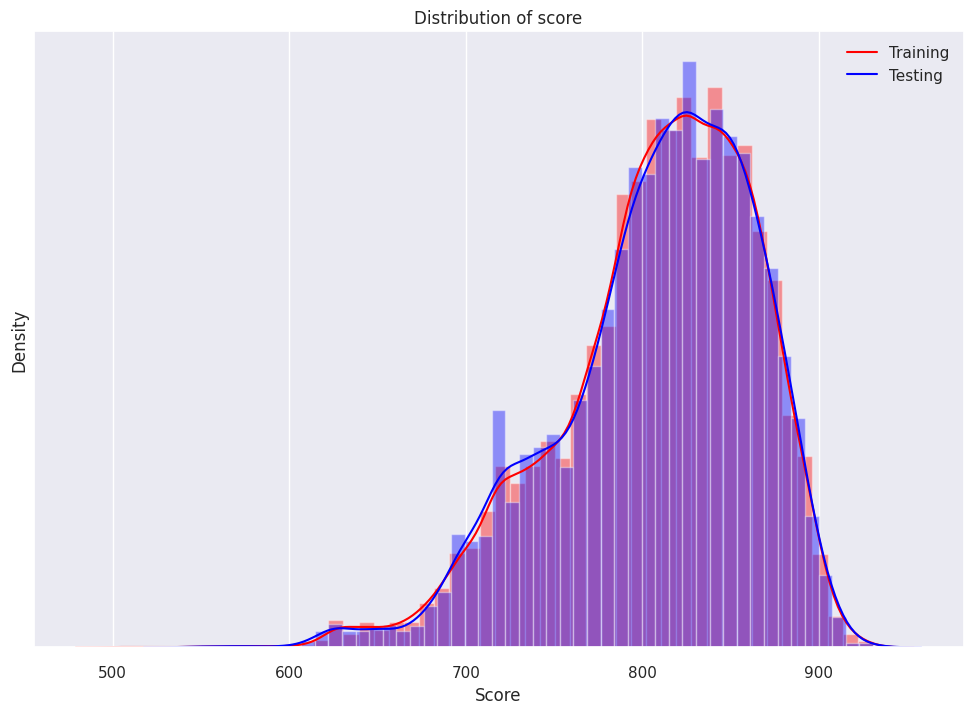

In [62]:
plt.figure(figsize = (12,8))
sns.distplot(train_logic['Score'], color = 'red')
sns.distplot(test_logic['Score'], color = 'blue')
plt.yticks([])
plt.legend(('Training','Testing'))
plt.title('Distribution of score')

### Apply model to data

In [63]:
#factor
x_col_name2 = x_col_name.drop(['WOE_cb_person_default_on_file','WOE_loan_int_rate_interval','WOE_loan_amount_interval'],axis=1)
x_factor2 = x_col_name2.columns

X = df_logic[x_factor2]

model_to_data = sm.Logit(df_logic['loan_status'],sm.add_constant(X))
model_real = model_to_data.fit()
print(model_real.summary())

Optimization terminated successfully.
         Current function value: 0.333292
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                28501
Model:                          Logit   Df Residuals:                    28494
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                  0.3630
Time:                        10:07:07   Log-Likelihood:                -9499.1
converged:                       True   LL-Null:                       -14913.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.3555      0.019     69.71

In [64]:
#Calculate score

#factor = pdo / log(2)
df_logic['factor'] = pts_double_odds / np.log(2)
#offset = score-(factor*ln(odd))
df_logic['offset'] = max_score - df_logic['factor'] * np.log(target_odds)
#calculate p
df_logic['p'] = model_real.predict()
#calculat logit(p)
df_logic['Logit'] = np.log(df_logic['p'] / (1 - df_logic['p']))
df_logic['Score'] = df_logic['offset'] + df_logic['factor'] * df_logic['Logit']
df_logic['Score'] = df_logic['Score']*850 / df_logic['Score'].max()


In [65]:
df_logic.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,WOE_loan_int_rate_interval,WOE_Age_interval,WOE_loan_amount_interval,WOE_cb_person_default_on_file,WOE_emp_length_interval,factor,offset,p,Logit,Score
0,22,59000,RENT,25.0,PERSONAL,D,35000,16.02,0,0.59,...,1.333538,0.211025,0.560622,0.786166,-0.309044,28.853901,751.862188,0.049431,-2.956489,610.784183
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,1,0.10,...,-0.353336,0.211025,-0.104164,-0.219954,-0.101836,28.853901,751.862188,0.981664,3.980392,794.192879
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0,0.57,...,-0.072182,0.036484,-0.297812,-0.219954,0.344117,28.853901,751.862188,0.241934,-1.142107,658.755802
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0,0.53,...,1.333538,-0.019230,0.560622,-0.219954,-0.101836,28.853901,751.862188,0.175957,-1.543986,648.130266
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0,0.55,...,1.333538,0.005647,0.560622,0.786166,-0.209283,28.853901,751.862188,0.183702,-1.491467,649.518847


In [67]:
factor = ['person_home_ownership','loan_percent_income_interval','emp_length_interval','loan_grade','loan_intent','income_interval']

factor_final = factor_sum.set_index('Factor').loc[factor]
factor_final = factor_final[['Interval','WOE']]
factor_final['const'] = model_real.params[0]
factor_final['n'] = len(model_real.params) - 1
factor_final['factor'] = pts_double_odds / np.log(2)
factor_final['offset'] = max_score - factor_final['factor'] * np.log(target_odds)

##Coefficient from model

coef = pd.DataFrame(model_real.params[1:], columns = ['coef'])
coef_names = factor
coef['Factor'] = coef_names
coef = coef.set_index(coef['Factor']).drop(['Factor'], axis = 1)
coef

factor_final = pd.merge(
    factor_final,
    coef,
    how = 'left',
    left_index = True,
    right_index = True
)

factor_final['Score'] = (factor_final['offset'] / factor_final['n']) + (factor_final['factor'] * (factor_final['WOE'] * factor_final['coef'] + (factor_final['const'] / factor_final['n'])))

In [68]:
factor_final

,Interval,WOE,const,n,factor,offset,coef,Score
Factor,,,,,,,,
emp_length_interval,"(-0.001, 1.0]",0.344117,1.355549,6,28.853901,751.862188,-0.968489,122.212942
emp_length_interval,"(1.0, 3.0]",0.082799,1.355549,6,28.853901,751.862188,-0.968489,129.515394
emp_length_interval,"(3.0, 5.0]",-0.101836,1.355549,6,28.853901,751.862188,-0.968489,134.674943
emp_length_interval,"(5.0, 8.0]",-0.209283,1.355549,6,28.853901,751.862188,-0.968489,137.677521
emp_length_interval,"(8.0, 25.0]",-0.309044,1.355549,6,28.853901,751.862188,-0.968489,140.465320
income_interval,low,0.507496,1.355549,6,28.853901,751.862188,-0.488788,124.671736
income_interval,low-middle,-0.372200,1.355549,6,28.853901,751.862188,-0.488788,137.078468
income_interval,middle,-0.987726,1.355549,6,28.853901,751.862188,-0.488788,145.759504
income_interval,high-middle,-0.994349,1.355549,6,28.853901,751.862188,-0.488788,145.852908


### The characteristic who obtain the highest score

In [70]:
df_logic[df_logic['Score'] == df_logic['Score'].max()][factor]

,person_home_ownership,loan_percent_income_interval,emp_length_interval,loan_grade,loan_intent,income_interval
13712,OWN,"(-0.001, 0.05]","(5.0, 8.0]",A,VENTURE,high-middle
13839,OWN,"(-0.001, 0.05]","(5.0, 8.0]",A,VENTURE,high-middle
25563,OWN,"(-0.001, 0.05]","(5.0, 8.0]",A,VENTURE,high-middle
27833,OWN,"(-0.001, 0.05]","(5.0, 8.0]",A,VENTURE,high-middle
28095,OWN,"(-0.001, 0.05]","(5.0, 8.0]",A,VENTURE,high-middle


We found 5 people with the highest credit score.
All 5 people have same characteristhat that

- Income : High-middle, 145.348 points
- Home_ownership : OWN, 167.265 points
- Employee length : 5-8, 132.324 points
- Loan intent : Venture , 148.636 points
- Loan per income : 0-0.05 , 156.975 points
- Loan grade : A , 162.325 points


In [71]:
# Score card
score_bins = [300, 570, 669, 739, 799, 851]
score_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
df_logic['Score_Category'] = pd.cut(df_logic['Score'], bins=score_bins, labels=score_labels, right=False)


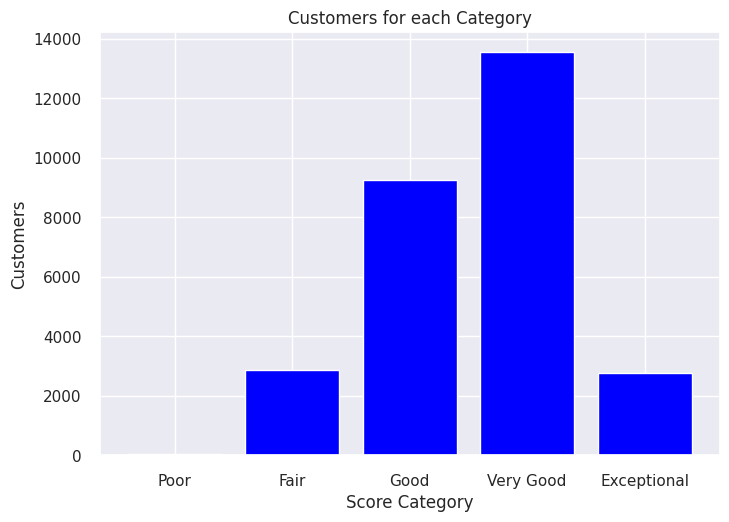

In [72]:
score_labels_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
score_category_counts = df_logic['Score_Category'].value_counts().loc[score_labels_order]

# Plot a bar chart
plt.bar(score_category_counts.index, score_category_counts.values, color='blue')
plt.xlabel('Score Category')
plt.ylabel('Customers')
plt.title('Customers for each Category')
plt.show()


## Applied Random forest regression to calculate credit score

### Training

In [102]:
from sklearn.ensemble import RandomForestRegressor

#WOE column
x_col_name = df_logic.filter(regex='^WOE')
#remove column
x_col_name = x_col_name.drop('WOE_Age_interval',axis=1)
x_factor = x_col_name.columns
# Split the data into training and testing sets
train_logic_rf, test_logic_rf = train_test_split(df_logic, test_size=0.3, random_state=40)

# Define the features (x_factor) and target variable (loan_status)
X_train = train_logic_rf[x_factor]
y_train = train_logic_rf['loan_status']
X_test = test_logic_rf[x_factor]
y_test = test_logic_rf['loan_status']

# Create and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=40)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_train)

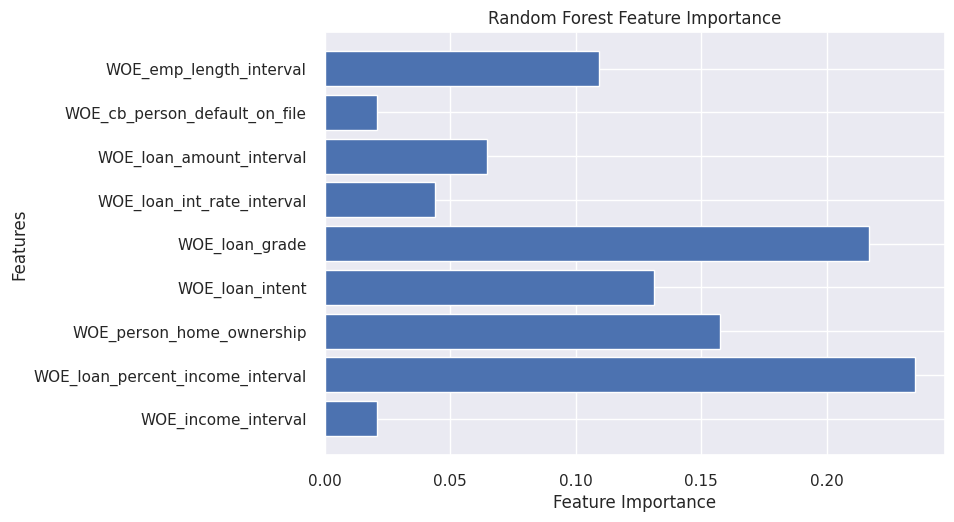

In [103]:
feature_importances = rf_model.feature_importances_
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

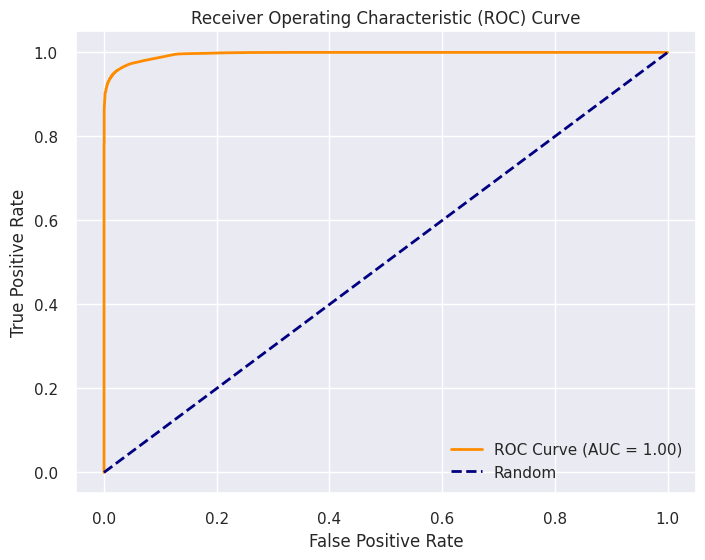

In [104]:
plot_roc_curve(y_train,y_pred)

In [105]:
# Calculate AUC
auc_score = roc_auc_score(y_train, y_pred)
print("AUC:", auc_score)

# Calculate GINI
gini_score = 2 * auc_score - 1
print("GINI:", gini_score)

# Calculate KS
y_train_ks = pd.DataFrame(train_logic['loan_status'])
y_train_ks['y_pred'] = y_pred
ks_statistic = stats.ks_2samp(y_train_ks[y_train_ks['loan_status'] == 0]['y_pred'], y_train_ks[y_train_ks['loan_status'] == 1]['y_pred']).statistic
print("KS:", ks_statistic)

# Calculate MSE
mse_score = mean_squared_error(y_train, y_pred)
print("MSE:", mse_score)

AUC: 0.9961600051739884
GINI: 0.9923200103479768
KS: 0.009518724819322227
MSE: 0.024450861473472668


### Testing

In [106]:
# Model
rf_model_test = RandomForestRegressor(random_state=40)
rf_model_test.fit(X_test, y_test)

# Make predictions on the test set
y_pred_test = rf_model_test.predict(X_test)

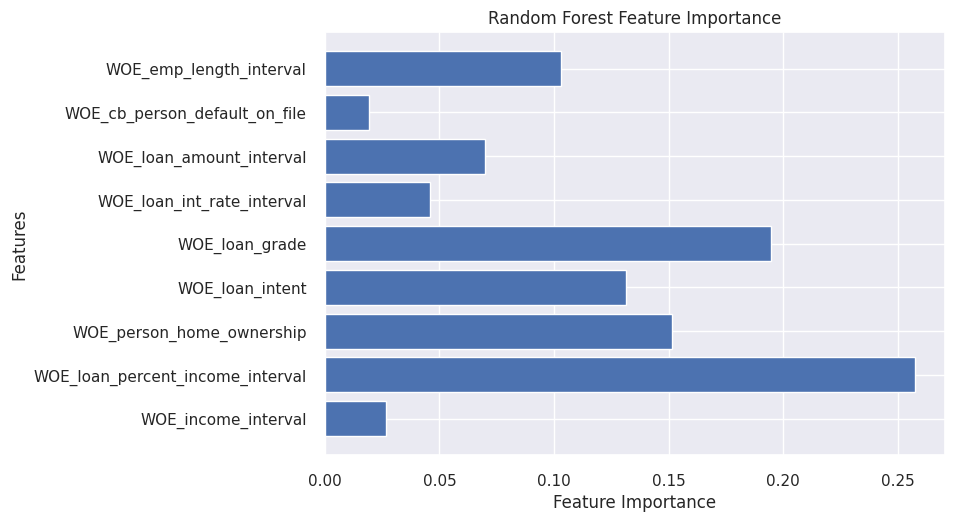

In [107]:
feature_importances = rf_model_test.feature_importances_
plt.barh(X_test.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

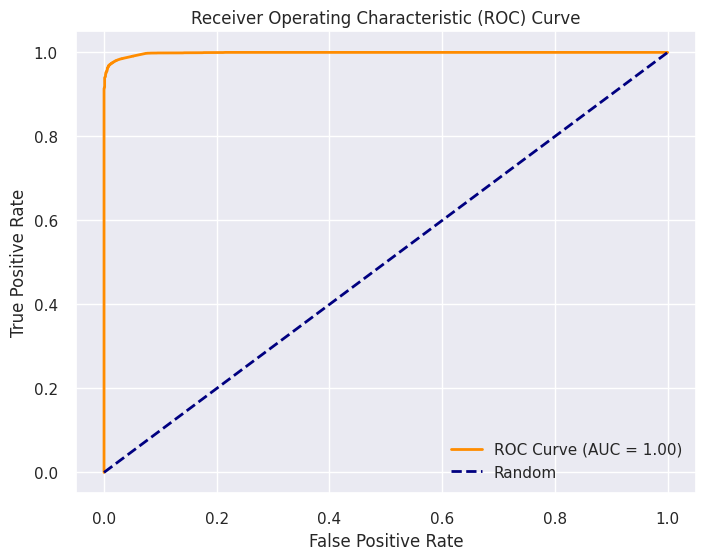

In [108]:
plot_roc_curve(y_test,y_pred_test)

In [109]:
# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC:", auc_score)

# Calculate GINI
gini_score = 2 * auc_score - 1
print("GINI:", gini_score)

# Calculate KS
y_test_ks = pd.DataFrame(test_logic['loan_status'])
y_test_ks['y_pred'] = y_pred_test
ks_statistic = stats.ks_2samp(y_test_ks[y_test_ks['loan_status'] == 0]['y_pred'], y_test_ks[y_test_ks['loan_status'] == 1]['y_pred']).statistic
print("KS:", ks_statistic)

# Calculate MSE
mse_score = mean_squared_error(y_test, y_pred_test)
print("MSE:", mse_score)

AUC: 0.9985893392314681
GINI: 0.9971786784629362
KS: 0.017231876419374053
MSE: 0.019862440945300288


In [110]:
# Calculate score manually
def scale_predictions(predictions, target_range=(300, 850)):
    min_target, max_target = target_range
    min_prediction, max_prediction = predictions.min(), predictions.max()
    # Linear scaling formula
    scaled_predictions = min_target + (max_target - min_target) * (predictions - min_prediction) / (max_prediction - min_prediction)
    return scaled_predictions

In [111]:
train_logic_rf['Score'] = scale_predictions(y_pred)
test_logic_rf['Score'] = scale_predictions(y_pred_test)

Text(0.5, 1.0, 'Distribution of score')

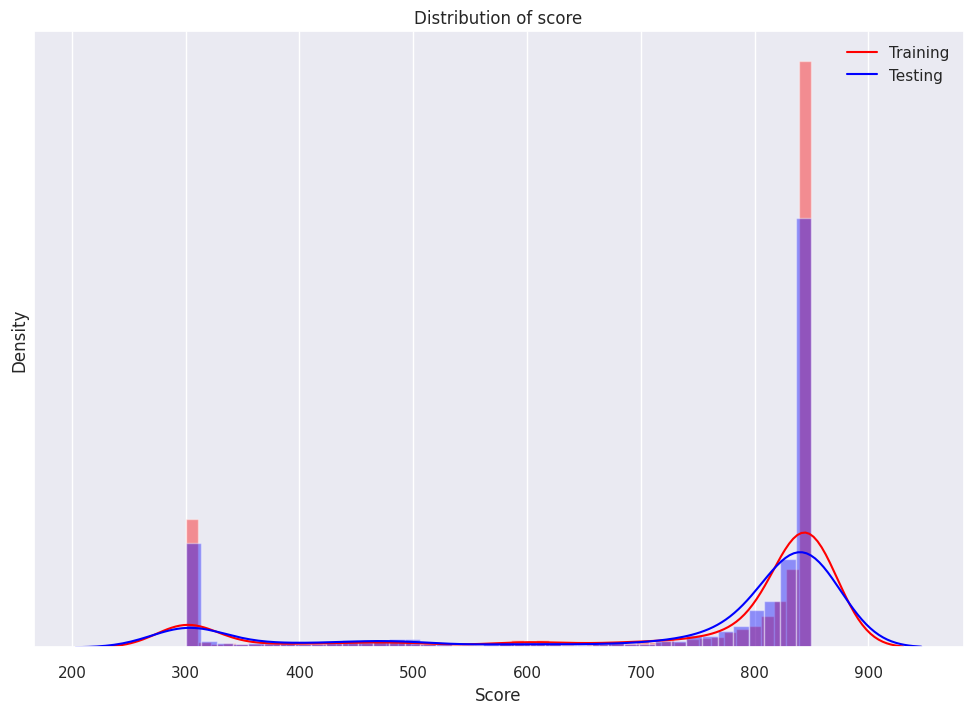

In [112]:
plt.figure(figsize = (12,8))
sns.distplot(train_logic_rf['Score'], color = 'red')
sns.distplot(test_logic_rf['Score'], color = 'blue')
plt.yticks([])
plt.legend(('Training','Testing'))
plt.title('Distribution of score')

### Apply to full data

In [113]:
#factor
X = df_logic[x_factor]

RF_model_data = RandomForestRegressor(random_state=40)
RF_model_data.fit(X,df_logic['loan_status'])
y_pred_rf_data = RF_model_data.predict(X)
credit_scores = scale_predictions(y_pred_rf_data)
df_logic['Score_RF'] = credit_scores
score_bins = [300, 570, 669, 739, 799, 851]
score_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
df_logic['Score_Category_RF'] = pd.cut(df_logic['Score_RF'], bins=score_bins, labels=score_labels, right=False)

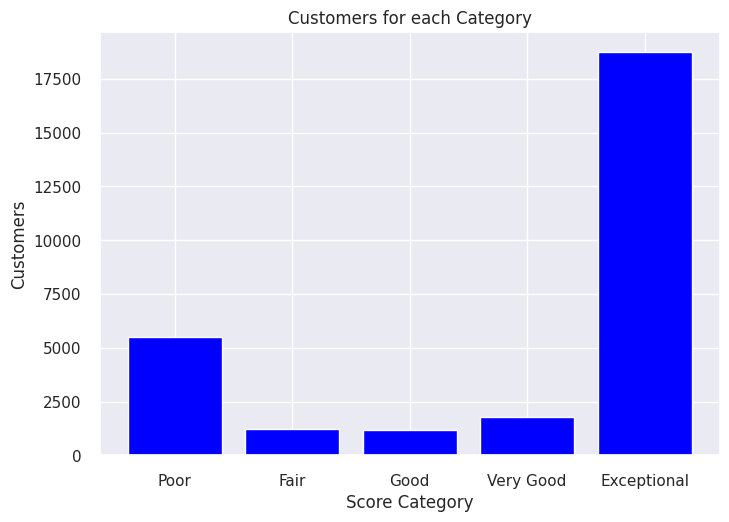

In [116]:
score_labels_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
score_category_counts_RF = df_logic['Score_Category_RF'].value_counts().loc[score_labels_order]

# Plot a bar chart
plt.bar(score_category_counts_RF.index, score_category_counts_RF.values, color='blue')
plt.xlabel('Score Category')
plt.ylabel('Customers')
plt.title('Customers for each Category')
plt.show()

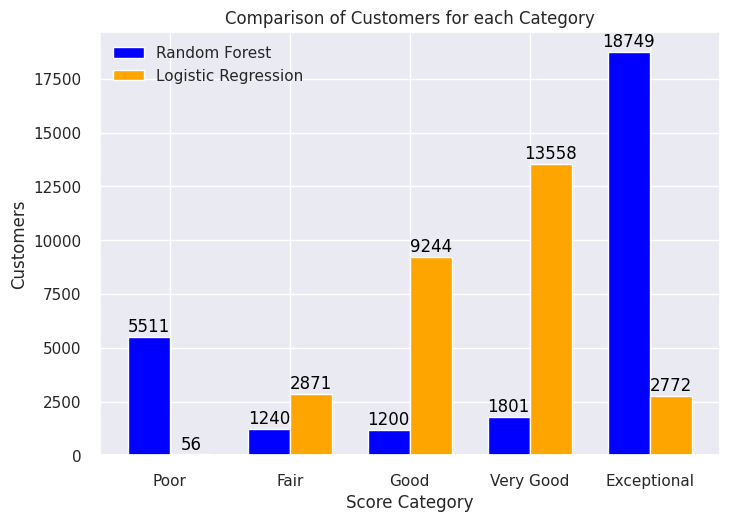

In [118]:
score_labels_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# Get counts for 'Score_Category_RF'
score_category_counts_RF = df_logic['Score_Category_RF'].value_counts().loc[score_labels_order]

# Get counts for 'Score_Category'
score_category_counts = df_logic['Score_Category'].value_counts().loc[score_labels_order]

# Plot a grouped bar chart with annotations
bar_width = 0.35
index = range(len(score_labels_order))

plt.bar([i - bar_width/2 for i in index], score_category_counts_RF.values, width=bar_width, label='Random Forest', color='blue')
plt.bar([i + bar_width/2 for i in index], score_category_counts.values, width=bar_width, label='Logistic Regression', color='orange')

plt.xlabel('Score Category')
plt.ylabel('Customers')
plt.title('Comparison of Customers for each Category')
plt.xticks(index, score_labels_order)
plt.legend()

# Add annotations
for i, count_RF, count_logistic in zip(index, score_category_counts_RF.values, score_category_counts.values):
    plt.text(i - bar_width/2, count_RF + 50, str(count_RF), ha='center', va='bottom', color='black')
    plt.text(i + bar_width/2, count_logistic + 50, str(count_logistic), ha='center', va='bottom', color='black')

plt.show()



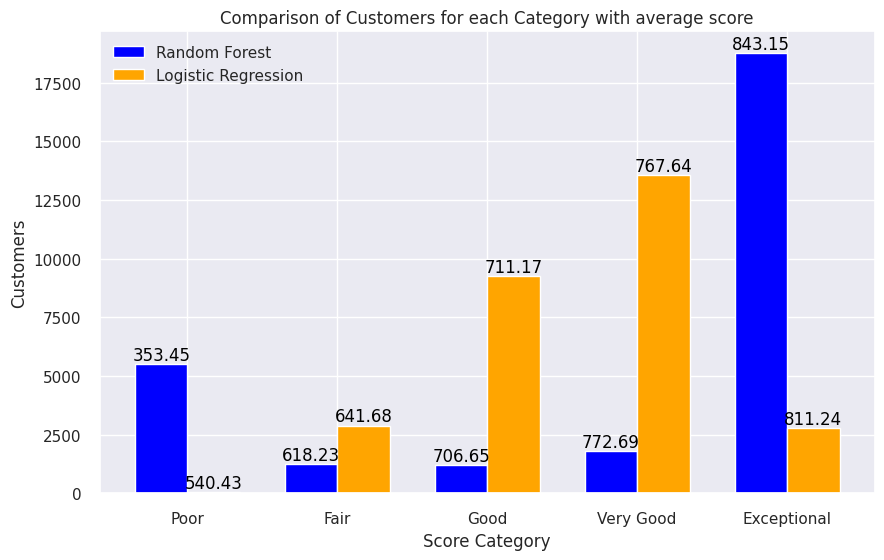

In [136]:
import matplotlib.pyplot as plt

score_labels_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# Get counts for 'Score_Category_RF'
score_category_counts_RF = df_logic['Score_Category_RF'].value_counts().loc[score_labels_order]

# Get mean scores for 'Score_Category_RF'
mean_scores_RF = [df_logic['Score_RF'][df_logic['Score_Category_RF'] == cat].mean() for cat in score_labels_order]

# Get counts for 'Score_Category'
score_category_counts = df_logic['Score_Category'].value_counts().loc[score_labels_order]

# Get mean scores for 'Score_Category'
mean_scores = [df_logic['Score'][df_logic['Score_Category'] == cat].mean() for cat in score_labels_order]

# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot a grouped bar chart with annotations for mean scores only
bar_width = 0.35
index = range(len(score_labels_order))

bars_RF = plt.bar([i - bar_width/2 for i in index], score_category_counts_RF.values, width=bar_width, label='Random Forest', color='blue')
bars_logistic = plt.bar([i + bar_width/2 for i in index], score_category_counts.values, width=bar_width, label='Logistic Regression', color='orange')

plt.xlabel('Score Category')
plt.ylabel('Customers')
plt.title('Comparison of Customers for each Category with average score')
plt.xticks(index, score_labels_order)
plt.legend()

# Add annotations for mean scores inside each bar
for bar_RF, bar_logistic, mean_score_RF, mean_score_logistic in zip(bars_RF, bars_logistic, mean_scores_RF, mean_scores):
    plt.text(bar_RF.get_x() + bar_RF.get_width()/2, bar_RF.get_height() + 20, f'{mean_score_RF:.2f}', ha='center', va='bottom', color='black')
    plt.text(bar_logistic.get_x() + bar_logistic.get_width()/2, bar_logistic.get_height() + 20, f'{mean_score_logistic:.2f}', ha='center', va='bottom', color='black')

plt.show()
